<a href="https://colab.research.google.com/github/blackdragon18/FMML-2021/blob/main/Final_Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

IMAGE_SIZE = (299, 299)  # InceptionResNetV2 input size
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001
NUM_CLASSES = 4


train_dir = r'/content/drive/MyDrive/brain tumor 1/Training'
test_dir = r'/content/drive/MyDrive/brain tumor 1/Testing'

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
#Loading the dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

#InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

# Adding custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers for initial training
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train the model on the initial layers
history = model.fit(
    train_generator,
    epochs=EPOCHS // 2,  # Train the initial layers for a portion of the total epochs
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[:200]:  # Unfreeze a portion of the layers
    layer.trainable = True

# Compile the model again after unfreezing
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history = model.fit(
    train_generator,
    initial_epoch=EPOCHS // 2,  # Continue training from where it left off
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Save the model
model.save(r'/content/drive/MyDrive/new_model.h5')

Found 5722 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
219055592/219055592 [==============================] - 1s 0us/step
Epoch 1/15
179/179 [==============================] - 2070s 11s/step - loss: 0.7655 - accuracy: 0.7534 - val_loss: 0.6418 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 2/15
179/179 [==============================] - 224s 1s/step - loss: 0.5307 - accuracy: 0.8167 - val_loss: 0.6616 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 3/15
179/179 [==============================] - 225s 1s/step - loss: 0.4690 - accuracy: 0.8315 - val_loss: 0.4875 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 4/15
179/179 [==============================] - 227s 1s/step - loss: 0.3995 - accuracy: 0.8521 - val_loss: 0.3862 - val_accuracy: 0.8627 - lr: 0.0010
Epoch 5/15
179/179 [==============================] - 226s 1s/step - loss: 0.3992 - accuracy: 0.8555 - val_loss: 0.4854 - val_accuracy: 0.8345 - lr: 0.0010
Epoch 6/15
179/179 [==============================] - 232s 1s/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 20s 360ms/step


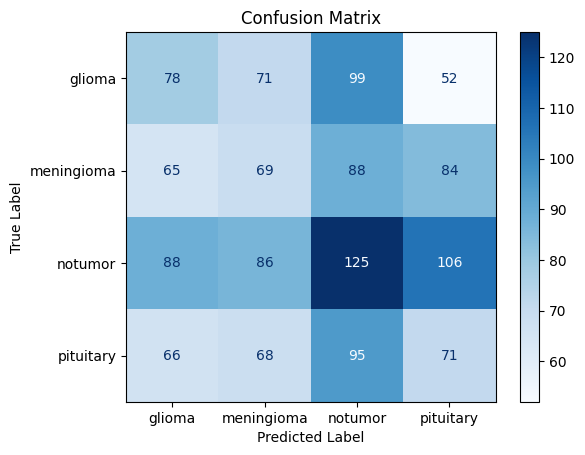

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the saved model
model_path = r'/content/drive/MyDrive/new_model.h5'
model = tf.keras.models.load_model(model_path)

# Generate predictions using the model and test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


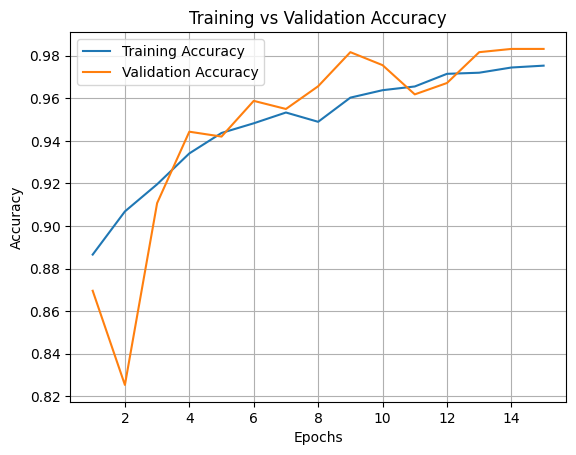

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have loaded the history_dict from your training

# Extracting the number of epochs from the history
epochs = range(1, len(history_dict['accuracy']) + 1)

# Plotting training vs validation accuracy
plt.plot(epochs, history_dict['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Found 1311 images belonging to 4 classes.
41/41 [==============================] - 15s 376ms/step


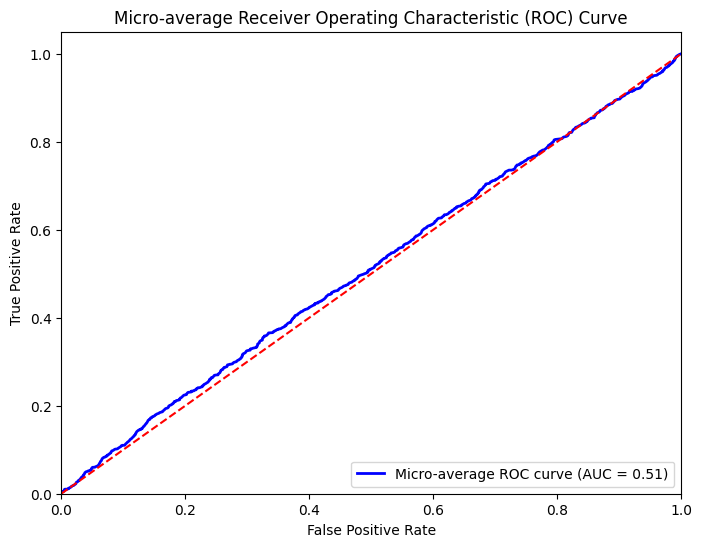

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Assuming you have predictions and true labels from your prediction code
predictions = model.predict(test_generator)
true_labels = test_generator.classes

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average the TPR over classes
mean_tpr /= NUM_CLASSES

fpr["micro"] = all_fpr
tpr["micro"] = mean_tpr
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
